# PyTorch Tutorial 1: vision Transformer (viT)

### 1. prerequisite

**Note**
1. `eniops` is a powerful pylib used for tensor operations in deep learning. If you have questions about its usage, please read the [official documentation](https://einops.rocks/)

In [16]:
# import some necessary packages
import os
import numpy as np
import torch
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
from torchvision.datasets import mnist
from torchvision.transforms import ToTensor

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Current device: {device}')

Current device: cuda


In [18]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

### 2. Multi-Head Self-Attention (MHSA)

In [19]:
class Attention(nn.Module):
    def __init__(
        self, 
        dim, 
        heads = 8, 
        dim_head = 64, 
        dropout = 0.0
    ):
        super().__init__()
        inner_dim = dim_head *  heads
        # ensure that
        # 1. there are more than 1 head in MHSA
        # 2. the value of `dim` is not being changed after MHSA
        assert isinstance(heads, int), "The type of heads should be `int`"
        assert heads > 1, "The number of heads should be larger than 1"
        assert dim_head != dim, "The value of `dim` (input) can not be equal to `dim_head` (output)"

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(dropout)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # pre-norm
        x = self.norm(x)
        
        qkv = self.to_qkv(x)
        # Notes:
        # 1. we do not initialize three `nn.Linear` instances for W_q, W_k and W_v.
        # 2. you can read the PyTorch documentation to learn more details about `torch.chunk()`. 
        qkv = qkv.chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
        
        attn_scores = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = F.softmax(attn_scores, dim=-1)
        attn = self.dropout(attn)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        
        return self.to_out(out)


### 2. Feed Forward Network (FFN)

In [20]:
class FFN(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.0):
        super().__init__()
        
        self.mlp = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.mlp(x)

### 3. Transformer Encoder

In [21]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.0):
        super().__init__()
        
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim=dim, heads=heads, dim_head=dim_head, dropout=dropout),
                FFN(dim=dim, hidden_dim=mlp_dim, dropout=dropout)
            ]))

    def forward(self, x):
        for mha, ffn in self.layers:
            x = mha(x) + x
            x = ffn(x) + x

        return x

### 4. viT

In [22]:
class ViT(nn.Module):
    def __init__(
        self, 
        image_size, 
        patch_size, 
        num_classes, 
        dim, 
        depth, 
        heads, 
        mlp_dim, 
        channels = 3, 
        dim_head = 64, 
        dropout = 0.0, 
        emb_dropout = 0.0
    ):
        super().__init__()
        
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, \
            'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
# Patch embedding
        x = self.to_patch_embedding(img)

# Position embedding
        B, N, _ = x.shape
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(N + 1)] # Adding the position embedding
        x = self.dropout(x)

        # Transformer encoder
        x = self.transformer(x)

        # We only use the `cls` token for classification
        cls_token = x[:, 0]
        logits = self.mlp_head(cls_token)

        return logits


        # position embedding



        # transformer encoder

        # we only use the `cls` token




### 5. Model Initialization

In [23]:
# define ViT model
model = ViT(
    image_size = 28,
    patch_size = 4,
    num_classes = 10,
    dim = 128,
    depth = 3,
    heads = 4,
    channels = 1,
    mlp_dim = 256,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

In [24]:
# you can try to adjust the following hyperparameters,
# and find the performance change
lr = 5e-2
all_epoch = 10
batch_size = 256

### 6. Data Pipeline

In [25]:
# data pipeline
train_dataset = mnist.MNIST(
    root='./mnist_data',
    download=True,
    train=True,
    transform=ToTensor()
)
test_dataset = mnist.MNIST(
    root='./mnist_data',
    download=False,
    train=False,
    transform=ToTensor()
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### 7. Training & Evaluation

In [26]:
# optimizer
optimizer = SGD(model.parameters(), lr=lr)

In [27]:
# loss function
loss_fn = CrossEntropyLoss()

In [28]:
losses = []

for current_epoch in range(all_epoch):
    # training
    model.train()
    for idx, (train_x, train_label) in enumerate(train_loader):
        train_x = train_x.to(device)
        train_label = train_label.to(device)

        predict_y = model(train_x.float())
        loss = loss_fn(predict_y, train_label.long())
        # clear the gradient
        optimizer.zero_grad()
        # back prop
        loss.backward()
        # update model params
        optimizer.step()

        if (idx + 1) % 25 == 0:
            losses.append(loss.item())

    # evaluation
    model.eval()
    
    all_correct_num = 0
    all_sample_num = 0
    
    for idx, (test_x, test_label) in enumerate(test_loader):
        test_x = test_x.to(device)
        test_label = test_label.to(device)

        predict_y = model(test_x.float()).detach()
        predict_y =torch.argmax(predict_y, dim=-1)

        current_correct_num = (predict_y == test_label)
        all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
        all_sample_num += current_correct_num.shape[0]
    acc = all_correct_num / all_sample_num

    print(f'Epoch [{current_epoch+1}/{all_epoch}], accuracy: {acc:.3f}')

    if not os.path.isdir('models'):
        os.mkdir('models')
    torch.save(model, f'models/mnist_{acc:.3f}.pt')

print('Training finished!')

Epoch [1/10], accuracy: 0.449
Epoch [2/10], accuracy: 0.813
Epoch [3/10], accuracy: 0.869
Epoch [4/10], accuracy: 0.894
Epoch [5/10], accuracy: 0.902
Epoch [6/10], accuracy: 0.916
Epoch [7/10], accuracy: 0.932
Epoch [8/10], accuracy: 0.943
Epoch [9/10], accuracy: 0.947
Epoch [10/10], accuracy: 0.953
Training finished!


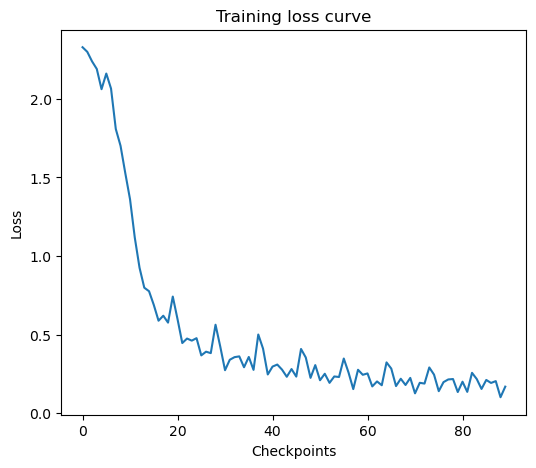

In [29]:
# loss curve visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(losses)
plt.xlabel("Checkpoints")
plt.ylabel("Loss")
plt.title("Training loss curve")
plt.show()